# HMDB Results

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import Draw
from keras.models import Sequential, Model, load_model

Using TensorFlow backend.


In [3]:
import sys
sys.path.append('..')

from molecules.model import MoleculeVAE
from molecules.utils import one_hot_array, one_hot_index, from_one_hot_array, \
    decode_smiles_from_indexes, load_dataset

## 1. Model

The aim is to learn a continuous vector embedding of molecules based on their SMILES descriptors. This is based on the Molecular Variational Autoencoder (MVAE) model described in [1].

[1] Gómez-Bombarelli, Rafael, et al. "[Automatic chemical design using a data-driven continuous representation of molecules.](https://arxiv.org/abs/1610.02415)" arXiv preprint arXiv:1610.02415 (2016).

![Molecular Variational Autoencoder](https://raw.githubusercontent.com/maxhodak/keras-molecules/master/images/network.png)

## 2. Data

In the paper, the model was evaluated on drug and OLED datasets. To determine the suitability of the model on metabolomics data, we use the ['All Metabolites' data](http://www.hmdb.ca/downloads) from HMDB. A big XML file of all metabolite compounds in HMDB was downloaded from the site. After parsing, we get ~50k molecules. Entries that don't have SMILES were discarded. The resulting molecules are split into training (80%) and test (20%) sets: 

- Training set: 36899 molecules
- Test set: 9225 molecules

The following pre-processing steps were performed on the SMILES strings of the molecules:

- Normalizes the length of each string to 120 by appending whitespace as needed.
- Builds a list of the unique characters used in the dataset. (The "charset")
- Substitutes each character in each SMILES string with the integer ID of its location in the charset.
- Converts each character position to a one-hot vector of len(charset).

and they're used as input to train the MVAE model.

## 3. Some useful functions

In [4]:
def load_data_and_model(data_file, model_file, latent_dim):
    model = MoleculeVAE()
    data, data_test, charset = load_dataset(data_file)
    model.load(charset, model_file, latent_rep_size=latent_dim)
    return model, data, data_test, charset

In [5]:
def to_dataframe(data, model, latent_dim, N=20):

    x_latent = model.encoder.predict(data)    

    rows = []
    for i in range(len(data[:N])):

        mol = decode_smiles_from_indexes(map(from_one_hot_array, data[i]), charset)
        encoded = x_latent[i]
        decoded = model.decoder.predict(encoded.reshape(1, latent_dim)).argmax(axis=2)[0]
        decoded_smiles = decode_smiles_from_indexes(decoded, charset)
    
        row = (mol, encoded, decoded_smiles)
        rows.append(row)
        
    df = pd.DataFrame(rows, columns=['SMILES', 'encoded', 'decoded'])
    return df

In [6]:
def visualize_latent_rep(data, model, latent_dim):
    
    PCA_COMPONENTS = 50
    TSNE_LEARNING_RATE = 750.0
    TSNE_ITERATIONS = 1000
    TSNE_COMPONENTS = 2
    TSNE_PERPLEXITY = 30.0    
    
    print("pca_comp=%d tsne_comp=%d tsne_perplexity=%f tsne_lr=%f" % (
        PCA_COMPONENTS,
        TSNE_COMPONENTS,
        TSNE_PERPLEXITY,
        TSNE_LEARNING_RATE
    ))

    pca = PCA(n_components = PCA_COMPONENTS)
    x_latent = model.encoder.predict(data)    
    x_latent = pca.fit_transform(x_latent)

    plt.figure(figsize=(6, 6))
    plt.scatter(x_latent[:, 0], x_latent[:, 1], marker='.')
    plt.title('PCA - Latent Dim %d' % latent_dim)
    plt.show()

    tsne = TSNE(n_components = TSNE_COMPONENTS,
                perplexity = TSNE_PERPLEXITY,
                learning_rate = TSNE_LEARNING_RATE,
                n_iter = TSNE_ITERATIONS,
                verbose = 4)
    x_latent_proj = tsne.fit_transform(x_latent)
    del x_latent

    plt.figure(figsize=(6, 6))
    plt.scatter(x_latent_proj[:, 0], x_latent_proj[:, 1], marker='.')
    plt.title('tSNE - Latent Dim %d' % latent_dim)    
    plt.show()

## 4. Results

The paper states that:

> We performed Bayesian optimization over hyperparameters specifying the deep autoencoder architecture and training, such as the choice between a recurrent or convolutional encoder, the number of hidden layers, layer sizes, regularization and learning rates. [32] We also ran an outer loop of optimization to determine how small the latent dimension could be while still producing reasonable reconstruction error.

and found that latent dimensions of 56 and 292 work best for their data. Below are some results using the same parameters on our HMDB data. 

### 4a. Latent dimensions = 56

The model was trained for 200 iterations (epochs). Here are the loss and reconstruction accuracy on the testing set so far (it's not finished yet):

VAE loss: http://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

>         def vae_loss(x, x_decoded_mean):
>            x = K.flatten(x)
>            x_decoded_mean = K.flatten(x_decoded_mean)
>            xent_loss = max_length * objectives.binary_crossentropy(x, x_decoded_mean)
>            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
>            return xent_loss + kl_loss

A reconstruction accuracy of 1.0 means the model can (1) decode the input to the latent space, and (2) encode it back to the input perfectly.

In [7]:
LATENT_DIM = 56

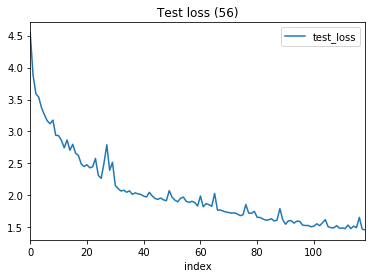

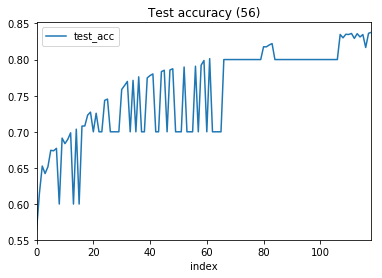

In [8]:
loss_acc = pd.read_csv('../loss_acc.csv')

loss_acc.reset_index().plot(x='index', y='test_loss')
plt.title('Test loss (%d)' % LATENT_DIM)

loss_acc.reset_index().plot(x='index', y='test_acc')
plt.title('Test accuracy (%d)' % LATENT_DIM)

Try to encode and decode some training SMILES, just to see how they look like.

In [9]:
model, data, data_test, charset = load_data_and_model(
    '../data/processed.h5', 
    '../data/hmdb_model_%d.h5' % LATENT_DIM, 
    LATENT_DIM)

In [10]:
df = to_dataframe(data, model, LATENT_DIM, N=100)

The 'SMILES' column is the original input. The 'decoded' column is the output from the model.

In [11]:
display(df[['SMILES', 'decoded']])

,SMILES,decoded
0,COC1=CC=C(C=C1)C(O)C(C(C)O)C1=CC=C(OC)C=C1,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1
1,CCC(C)C1\N=C(O)\C2C(CCN2C(=O)C(CC2=CC=CC=C2)\N...,CC1CCC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
2,CCCCCCCC1CC(C)OC1=O,CCCCCCCCCCCCCC(O)=O
3,CC(C)=CCC1=C(O)C=CC(C(=O)C2C(CC(C)=CC2C2=C(O)C...,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
4,CCCCCC1=NC(C)=C(C)O1,CCCCCCCCCCCCCCC(O)=O
5,[H][C@@](COC(=O)CCCCCCCCCCCCCC)(COP([O-])(=O)O...,[H][C@@](COC(=O)CCCCCCCCCCCCCC))COPP(O((())O)C...
6,CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(O)(=O)OCC(O)CO...,CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(O)(=O)OCC(O)CO...
7,CCCCCCCC\C=C/CCCCCCCC(=O)OC[C@]([H])(COP([O-])...,CCCCCCCC=C/CCCCCCCCCC(=O)OC[C@]([H])(COP([O-=O...
8,[H][C@](COC(=O)CCCCCCCCCCCCCCCCCCC)(COC(=O)CCC...,[H][C@](COC(=O)CCCCCCCCCCCCCCCCCCC)(COC(=O)CCC...
9,[H][C@](COC(=O)CCCCCCC\C=C/CCCCCCCC)(COC(=O)CC...,[H][C@](COC(=O)CCCCCCCCCCCCCCCCCCCC)(COC(=O)CC...


The results don't look too great??!! Particularly for the shorter SMILES, we see many things just replaced by 'C'.

Looking at the data, all the input with a lot of CCCCCCCCs seem to be triradyglycerols compounds (glycerolipids lipids containing a common glycerol backbone + fatty acyl group). Might be best to remove them?

Below we try to visualise the embedding. Instead of being evenly spread across the space as in the paper, molecules seem to be grouped together in a big cluster.

pca_comp=50 tsne_comp=2 tsne_perplexity=30.000000 tsne_lr=750.000000


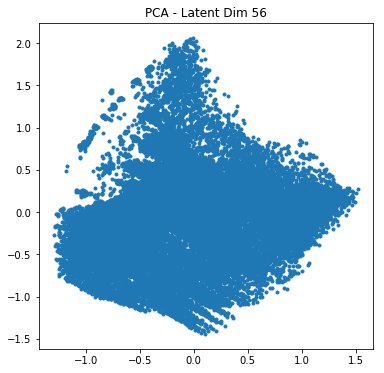

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 36899
[t-SNE] Computed conditional probabilities for sample 2000 / 36899
[t-SNE] Computed conditional probabilities for sample 3000 / 36899
[t-SNE] Computed conditional probabilities for sample 4000 / 36899
[t-SNE] Computed conditional probabilities for sample 5000 / 36899
[t-SNE] Computed conditional probabilities for sample 6000 / 36899
[t-SNE] Computed conditional probabilities for sample 7000 / 36899
[t-SNE] Computed conditional probabilities for sample 8000 / 36899
[t-SNE] Computed conditional probabilities for sample 9000 / 36899
[t-SNE] Computed conditional probabilities for sample 10000 / 36899
[t-SNE] Computed conditional probabilities for sample 11000 / 36899
[t-SNE] Computed conditional probabilities for sample 12000 / 36899
[t-SNE] Computed conditional probabilities for sample 13000 / 36899
[t-SNE] Computed conditional probabilities 

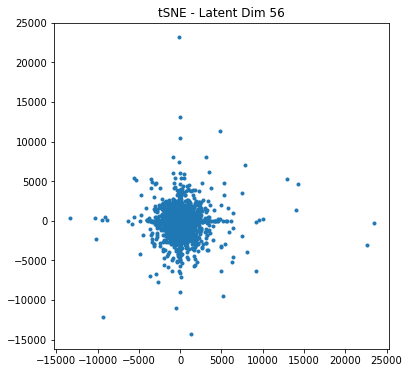

In [12]:
visualize_latent_rep(data, model, LATENT_DIM)

### 4b. Latent dimensions = 292

The model was trained for 100 iterations. I forgot to save the testing loss values, so no plots ..

In [13]:
LATENT_DIM = 292

In [14]:
model, data, data_test, charset = load_data_and_model(
    '../data/processed.h5', 
    '../data/hmdb_model_%d.h5' % LATENT_DIM, 
    LATENT_DIM)

In [15]:
df = to_dataframe(data, model, LATENT_DIM, N=100)

In [16]:
display(df[['SMILES', 'decoded']])

,SMILES,decoded
0,COC1=CC=C(C=C1)C(O)C(C(C)O)C1=CC=C(OC)C=C1,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC=C1
1,CCC(C)C1\N=C(O)\C2C(CCN2C(=O)C(CC2=CC=CC=C2)\N...,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
2,CCCCCCCC1CC(C)OC1=O,CCCCCCCCCCCCCC(O)=O
3,CC(C)=CCC1=C(O)C=CC(C(=O)C2C(CC(C)=CC2C2=C(O)C...,CC11CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
4,CCCCCC1=NC(C)=C(C)O1,CCCCCCCCCCCCCCC(O)=O
5,[H][C@@](COC(=O)CCCCCCCCCCCCCC)(COP([O-])(=O)O...,[H][C@@](COC(=O)CCCCCCCCCCCCCCCC))PP(---((OO==...
6,CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(O)(=O)OCC(O)CO...,CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(O)(=O)OCC(O)CO...
7,CCCCCCCC\C=C/CCCCCCCC(=O)OC[C@]([H])(COP([O-])...,CCCCCCCCCCCCCCCCCCCCC(=O)OC[C@]([H])(COP([O-](...
8,[H][C@](COC(=O)CCCCCCCCCCCCCCCCCCC)(COC(=O)CCC...,[H][C@](COC(=O)CCCCCCCCCCCCCCCCCCC)(COC(=O)CCC...
9,[H][C@](COC(=O)CCCCCCC\C=C/CCCCCCCC)(COC(=O)CC...,[H][C@](COC(=O)CCCCCCCCCCCCCCCCCCCC)(COC(=O)CC...


pca_comp=50 tsne_comp=2 tsne_perplexity=30.000000 tsne_lr=750.000000


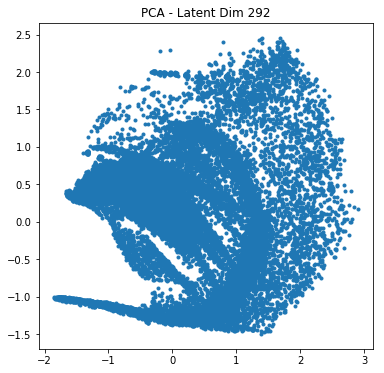

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 36899
[t-SNE] Computed conditional probabilities for sample 2000 / 36899
[t-SNE] Computed conditional probabilities for sample 3000 / 36899
[t-SNE] Computed conditional probabilities for sample 4000 / 36899
[t-SNE] Computed conditional probabilities for sample 5000 / 36899
[t-SNE] Computed conditional probabilities for sample 6000 / 36899
[t-SNE] Computed conditional probabilities for sample 7000 / 36899
[t-SNE] Computed conditional probabilities for sample 8000 / 36899
[t-SNE] Computed conditional probabilities for sample 9000 / 36899
[t-SNE] Computed conditional probabilities for sample 10000 / 36899
[t-SNE] Computed conditional probabilities for sample 11000 / 36899
[t-SNE] Computed conditional probabilities for sample 12000 / 36899
[t-SNE] Computed conditional probabilities for sample 13000 / 36899
[t-SNE] Computed conditional probabilities 

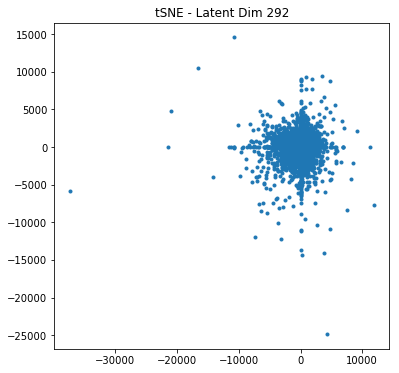

In [17]:
visualize_latent_rep(data, model, LATENT_DIM)

## 5. Things to investigate

- Run for a lot longer - any spare GPU lying around?
- Try a simpler model. First we need to obtain a high reconstruction accuracy on the test set.
- Get more/better data?
- Try a different (chemically meaningful??) loss function?
- How are metabolite SMILES different from drug/OLED SMILES used in the paper?